# Spiking-PointNet Baseline Reproduction

This notebook reproduces the baseline results from the Spiking-PointNet paper.

## Dataset Setup

Before running this notebook, you need to download the ModelNet40 dataset:

1. Download from: https://shapenet.cs.stanford.edu/media/modelnet40_normal_resampled.zip
2. Extract to: `data/modelnet40_normal_resampled/`

Alternatively, you can try downloading with:
```bash
cd data
wget https://shapenet.cs.stanford.edu/media/modelnet40_normal_resampled.zip
unzip modelnet40_normal_resampled.zip
```

## Environment Setup

Required packages:
- PyTorch >= 1.6.0
- numpy
- tqdm
- h5py

In [1]:
import os
import sys
import torch
import numpy as np
import datetime
import logging
import importlib
from pathlib import Path
from tqdm import tqdm

# Add parent directory to path
sys.path.append('..')
from data_utils.ModelNetDataLoader import ModelNetDataLoader
from models.spike_model import SpikeModel
import provider
import matplotlib.pyplot as plt
from cache_utils import save_training_history, cache_checkpoint
from viz_utils import plot_training_curves, summarize_histories, plot_metric_table, plot_metric_bars


## Configuration

In [2]:
class Args:
    def __init__(self):
        self.use_cpu = False
        self.gpu = '0'
        self.batch_size = 24
        self.model = 'pointnet_cls'
        self.num_category = 40  # 10 for ModelNet10, 40 for ModelNet40
        self.epoch = 200
        self.learning_rate = 0.001
        self.num_point = 1024
        self.optimizer = 'Adam'
        self.log_dir = 'baseline_spiking'
        self.decay_rate = 1e-4
        self.use_normals = False
        self.process_data = False
        self.use_uniform_sample = False
        self.thresh = 1
        self.T = 100
        self.shift_snn = 100
        self.step = 1  # Single timestep as per paper
        self.spike = True  # Use spiking network
        self.temp = 5.0

args = Args()
print(f"Configuration:")
print(f"  Model: {args.model}")
print(f"  Dataset: ModelNet{args.num_category}")
print(f"  Batch size: {args.batch_size}")
print(f"  Epochs: {args.epoch}")
print(f"  Spiking: {args.spike}")
print(f"  Timesteps: {args.step}")

Configuration:
  Model: pointnet_cls
  Dataset: ModelNet40
  Batch size: 24
  Epochs: 200
  Spiking: True
  Timesteps: 1


## Setup Directories and Logging

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = args.gpu

# Create directories
timestr = str(datetime.datetime.now().strftime('%Y-%m-%d_%H-%M'))
exp_dir = Path('../log/')
exp_dir.mkdir(exist_ok=True)
exp_dir = exp_dir.joinpath('classification')
exp_dir.mkdir(exist_ok=True)
exp_dir = exp_dir.joinpath(args.log_dir)
exp_dir.mkdir(exist_ok=True)
checkpoints_dir = exp_dir.joinpath('checkpoints/')
checkpoints_dir.mkdir(exist_ok=True)
log_dir = exp_dir.joinpath('logs/')
log_dir.mkdir(exist_ok=True)

print(f"Experiment directory: {exp_dir}")

Experiment directory: ..\log\classification\baseline_spiking


## Load Dataset

In [4]:
data_path = 'C:\\Users\\VIICTTE\\ML_Project\\modelnet40_normal_resampled'

print('Loading dataset...')
train_dataset = ModelNetDataLoader(root=data_path, args=args, split='train', process_data=args.process_data)
test_dataset = ModelNetDataLoader(root=data_path, args=args, split='test', process_data=args.process_data)
trainDataLoader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=4, drop_last=True)
testDataLoader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False, num_workers=4)

print(f"Training samples: {len(train_dataset)}")
print(f"Testing samples: {len(test_dataset)}")

Loading dataset...
The size of train data is 9843
The size of test data is 2468
Training samples: 9843
Testing samples: 2468


## Load Model

In [5]:
num_class = args.num_category
sys.path.append('../models')
model = importlib.import_module(args.model)

classifier = model.get_model(num_class, normal_channel=args.use_normals)

if args.spike:
    classifier = SpikeModel(classifier, args.step, args.temp)
    classifier.set_spike_state(True)
    print(f"Using Spiking PointNet with {args.step} timestep(s)")
else:
    print("Using standard PointNet")

criterion = model.get_loss()

if not args.use_cpu:
    classifier = classifier.cuda()
    criterion = criterion.cuda()

print(f"Model loaded successfully")

Using Spiking PointNet with 1 timestep(s)
Model loaded successfully


## Training Function

In [6]:
def test(model, loader, num_class=40):
    mean_correct = []
    class_acc = np.zeros((num_class, 3))
    classifier = model.eval()

    for j, (points, target) in tqdm(enumerate(loader), total=len(loader)):
        if not args.use_cpu:
            points, target = points.cuda(), target.cuda()

        points = points.transpose(2, 1)
        pred, _ = classifier(points)
        pred_choice = pred.data.max(1)[1]

        for cat in np.unique(target.cpu()):
            classacc = pred_choice[target == cat].eq(target[target == cat].long().data).cpu().sum()
            class_acc[cat, 0] += classacc.item() / float(points[target == cat].size()[0])
            class_acc[cat, 1] += 1

        correct = pred_choice.eq(target.long().data).cpu().sum()
        mean_correct.append(correct.item() / float(points.size()[0]))

    class_acc[:, 2] = class_acc[:, 0] / class_acc[:, 1]
    class_acc = np.mean(class_acc[:, 2])
    instance_acc = np.mean(mean_correct)

    return instance_acc, class_acc

## Setup Optimizer and Scheduler

In [7]:
if args.optimizer == 'Adam':
    optimizer = torch.optim.Adam(
        classifier.parameters(),
        lr=args.learning_rate,
        betas=(0.9, 0.999),
        eps=1e-08,
        weight_decay=args.decay_rate
    )
else:
    optimizer = torch.optim.SGD(classifier.parameters(), lr=0.01, momentum=0.9)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.7)

start_epoch = 0
best_instance_acc = 0.0
best_class_acc = 0.0

print("Optimizer and scheduler initialized")

Optimizer and scheduler initialized


## Training Loop

In [8]:
print('Starting training...')
training_history = []
best_checkpoint_path = None

for epoch in range(start_epoch, args.epoch):
    print(f'\nEpoch {epoch + 1}/{args.epoch}')
    mean_correct = []
    classifier = classifier.train()

    scheduler.step()
    
    for batch_id, (points, target) in tqdm(enumerate(trainDataLoader, 0), total=len(trainDataLoader), smoothing=0.9):
        optimizer.zero_grad()

        points = points.data.numpy()
        points = provider.random_point_dropout(points)
        points[:, :, 0:3] = provider.random_scale_point_cloud(points[:, :, 0:3])
        points[:, :, 0:3] = provider.shift_point_cloud(points[:, :, 0:3])
        points = torch.Tensor(points)
        points = points.transpose(2, 1)

        if not args.use_cpu:
            points, target = points.cuda(), target.cuda()

        pred, trans_feat = classifier(points)
        loss = criterion(pred, target.long(), trans_feat)
        pred_choice = pred.data.max(1)[1]

        correct = pred_choice.eq(target.long().data).cpu().sum()
        mean_correct.append(correct.item() / float(points.size()[0]))
        loss.backward()
        optimizer.step()

    train_instance_acc = np.mean(mean_correct)
    print(f'Train Instance Accuracy: {train_instance_acc:.4f}')

    with torch.no_grad():
        instance_acc, class_acc = test(classifier.eval(), testDataLoader, num_class=num_class)

        if instance_acc >= best_instance_acc:
            best_instance_acc = instance_acc
            best_epoch = epoch + 1

        if class_acc >= best_class_acc:
            best_class_acc = class_acc
            
        print(f'Test Instance Accuracy: {instance_acc:.4f}, Class Accuracy: {class_acc:.4f}')
        print(f'Best Instance Accuracy: {best_instance_acc:.4f}, Class Accuracy: {best_class_acc:.4f}')

        if instance_acc >= best_instance_acc:
            print('Saving model...')
            savepath = checkpoints_dir / 'best_model.pth'
            state = {
                'epoch': best_epoch,
                'instance_acc': instance_acc,
                'class_acc': class_acc,
                'model_state_dict': classifier.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }
            torch.save(state, savepath)
            best_checkpoint_path = savepath
        
        training_history.append({
            'epoch': epoch + 1,
            'train_acc': train_instance_acc,
            'test_instance_acc': instance_acc,
            'test_class_acc': class_acc
        })

print('\nTraining completed!')
history_path = save_training_history(
    training_history,
    'baseline_step_1',
    metadata={
        'best_instance_acc': best_instance_acc,
        'best_class_acc': best_class_acc,
        'best_epoch': best_epoch,
        'config': dict(vars(args)),
        'run_timestamp': timestr,
    },
)
print(f'Cached training history to {history_path}')
if best_checkpoint_path and best_checkpoint_path.exists():
    cached_ckpt = cache_checkpoint(best_checkpoint_path, 'baseline_step_1')
    print(f'Cached best checkpoint to {cached_ckpt}')
else:
    print('No best checkpoint available to cache.')


Starting training...

Epoch 1/200


100%|████████████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.42it/s]


Train Instance Accuracy: 0.4364


100%|████████████████████████████████████████████████████████████████████████████| 103/103 [00:03<00:00, 30.87it/s]


Test Instance Accuracy: 0.0809, Class Accuracy: 0.0503
Best Instance Accuracy: 0.0809, Class Accuracy: 0.0503
Saving model...

Epoch 2/200


100%|████████████████████████████████████████████████████████████████████████████| 410/410 [00:12<00:00, 32.38it/s]


Train Instance Accuracy: 0.5821


100%|████████████████████████████████████████████████████████████████████████████| 103/103 [00:03<00:00, 30.97it/s]


Test Instance Accuracy: 0.0392, Class Accuracy: 0.0275
Best Instance Accuracy: 0.0809, Class Accuracy: 0.0503

Epoch 3/200


100%|████████████████████████████████████████████████████████████████████████████| 410/410 [00:14<00:00, 27.41it/s]


Train Instance Accuracy: 0.6365


100%|████████████████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 34.44it/s]


Test Instance Accuracy: 0.1258, Class Accuracy: 0.1061
Best Instance Accuracy: 0.1258, Class Accuracy: 0.1061
Saving model...

Epoch 4/200


100%|████████████████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.40it/s]


Train Instance Accuracy: 0.6746


100%|████████████████████████████████████████████████████████████████████████████████| 103/103 [00:03<00:00, 34.29it/s]


Test Instance Accuracy: 0.1297, Class Accuracy: 0.1213
Best Instance Accuracy: 0.1297, Class Accuracy: 0.1213
Saving model...

Epoch 5/200


100%|████████████████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.56it/s]


Train Instance Accuracy: 0.6902


100%|████████████████████████████████████████████████████████████████████████████████| 103/103 [00:03<00:00, 33.40it/s]


Test Instance Accuracy: 0.1109, Class Accuracy: 0.1036
Best Instance Accuracy: 0.1297, Class Accuracy: 0.1213

Epoch 6/200


100%|████████████████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.80it/s]


Train Instance Accuracy: 0.7055


100%|████████████████████████████████████████████████████████████████████████████████| 103/103 [00:03<00:00, 33.94it/s]


Test Instance Accuracy: 0.0392, Class Accuracy: 0.0550
Best Instance Accuracy: 0.1297, Class Accuracy: 0.1213

Epoch 7/200


100%|████████████████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.46it/s]


Train Instance Accuracy: 0.7195


100%|████████████████████████████████████████████████████████████████████████████████| 103/103 [00:03<00:00, 34.01it/s]


Test Instance Accuracy: 0.1303, Class Accuracy: 0.1433
Best Instance Accuracy: 0.1303, Class Accuracy: 0.1433
Saving model...

Epoch 8/200


100%|████████████████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.30it/s]


Train Instance Accuracy: 0.7229


100%|████████████████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 34.85it/s]


Test Instance Accuracy: 0.1776, Class Accuracy: 0.1621
Best Instance Accuracy: 0.1776, Class Accuracy: 0.1621
Saving model...

Epoch 9/200


100%|████████████████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.47it/s]


Train Instance Accuracy: 0.7296


100%|████████████████████████████████████████████████████████████████████████████████| 103/103 [00:03<00:00, 33.45it/s]


Test Instance Accuracy: 0.1610, Class Accuracy: 0.1983
Best Instance Accuracy: 0.1776, Class Accuracy: 0.1983

Epoch 10/200


100%|████████████████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.54it/s]


Train Instance Accuracy: 0.7389


100%|████████████████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.12it/s]


Test Instance Accuracy: 0.2386, Class Accuracy: 0.2301
Best Instance Accuracy: 0.2386, Class Accuracy: 0.2301
Saving model...

Epoch 11/200


100%|████████████████████████████████████████████████████████████████████████████████| 410/410 [00:14<00:00, 29.27it/s]


Train Instance Accuracy: 0.7474


100%|████████████████████████████████████████████████████████████████████████████████| 103/103 [00:03<00:00, 33.80it/s]


Test Instance Accuracy: 0.1210, Class Accuracy: 0.1167
Best Instance Accuracy: 0.2386, Class Accuracy: 0.2301

Epoch 12/200


100%|████████████████████████████████████████████████████████████████████████████████| 410/410 [00:14<00:00, 29.23it/s]


Train Instance Accuracy: 0.7532


100%|████████████████████████████████████████████████████████████████████████████████| 103/103 [00:03<00:00, 34.24it/s]


Test Instance Accuracy: 0.1234, Class Accuracy: 0.1322
Best Instance Accuracy: 0.2386, Class Accuracy: 0.2301

Epoch 13/200


100%|████████████████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.82it/s]


Train Instance Accuracy: 0.7533


100%|████████████████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.23it/s]


Test Instance Accuracy: 0.2811, Class Accuracy: 0.2495
Best Instance Accuracy: 0.2811, Class Accuracy: 0.2495
Saving model...

Epoch 14/200


100%|████████████████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.61it/s]


Train Instance Accuracy: 0.7557


100%|████████████████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.00it/s]


Test Instance Accuracy: 0.0320, Class Accuracy: 0.0501
Best Instance Accuracy: 0.2811, Class Accuracy: 0.2495

Epoch 15/200


100%|████████████████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.88it/s]


Train Instance Accuracy: 0.7619


100%|████████████████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 34.84it/s]


Test Instance Accuracy: 0.1667, Class Accuracy: 0.1680
Best Instance Accuracy: 0.2811, Class Accuracy: 0.2495

Epoch 16/200


100%|████████████████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.61it/s]


Train Instance Accuracy: 0.7662


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 34.88it/s]


Test Instance Accuracy: 0.0239, Class Accuracy: 0.0425
Best Instance Accuracy: 0.2811, Class Accuracy: 0.2495

Epoch 17/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.58it/s]


Train Instance Accuracy: 0.7618


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 34.89it/s]


Test Instance Accuracy: 0.1363, Class Accuracy: 0.1373
Best Instance Accuracy: 0.2811, Class Accuracy: 0.2495

Epoch 18/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.65it/s]


Train Instance Accuracy: 0.7683


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 34.76it/s]


Test Instance Accuracy: 0.2278, Class Accuracy: 0.2038
Best Instance Accuracy: 0.2811, Class Accuracy: 0.2495

Epoch 19/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.11it/s]


Train Instance Accuracy: 0.7807


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.01it/s]


Test Instance Accuracy: 0.0591, Class Accuracy: 0.0572
Best Instance Accuracy: 0.2811, Class Accuracy: 0.2495

Epoch 20/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.82it/s]


Train Instance Accuracy: 0.7848


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:03<00:00, 33.93it/s]


Test Instance Accuracy: 0.2720, Class Accuracy: 0.2583
Best Instance Accuracy: 0.2811, Class Accuracy: 0.2583

Epoch 21/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.12it/s]


Train Instance Accuracy: 0.7910


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.12it/s]


Test Instance Accuracy: 0.0922, Class Accuracy: 0.0907
Best Instance Accuracy: 0.2811, Class Accuracy: 0.2583

Epoch 22/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.87it/s]


Train Instance Accuracy: 0.7971


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 34.89it/s]


Test Instance Accuracy: 0.0473, Class Accuracy: 0.0651
Best Instance Accuracy: 0.2811, Class Accuracy: 0.2583

Epoch 23/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.70it/s]


Train Instance Accuracy: 0.7960


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 34.62it/s]


Test Instance Accuracy: 0.2771, Class Accuracy: 0.2273
Best Instance Accuracy: 0.2811, Class Accuracy: 0.2583

Epoch 24/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.41it/s]


Train Instance Accuracy: 0.7953


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 34.71it/s]


Test Instance Accuracy: 0.0376, Class Accuracy: 0.0457
Best Instance Accuracy: 0.2811, Class Accuracy: 0.2583

Epoch 25/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.69it/s]


Train Instance Accuracy: 0.8040


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 34.71it/s]


Test Instance Accuracy: 0.0372, Class Accuracy: 0.0542
Best Instance Accuracy: 0.2811, Class Accuracy: 0.2583

Epoch 26/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.49it/s]


Train Instance Accuracy: 0.7980


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 34.80it/s]


Test Instance Accuracy: 0.0325, Class Accuracy: 0.0479
Best Instance Accuracy: 0.2811, Class Accuracy: 0.2583

Epoch 27/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.84it/s]


Train Instance Accuracy: 0.7989


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.22it/s]


Test Instance Accuracy: 0.0756, Class Accuracy: 0.0578
Best Instance Accuracy: 0.2811, Class Accuracy: 0.2583

Epoch 28/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.77it/s]


Train Instance Accuracy: 0.8001


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.27it/s]


Test Instance Accuracy: 0.0154, Class Accuracy: 0.0332
Best Instance Accuracy: 0.2811, Class Accuracy: 0.2583

Epoch 29/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.80it/s]


Train Instance Accuracy: 0.8039


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.17it/s]


Test Instance Accuracy: 0.0546, Class Accuracy: 0.0692
Best Instance Accuracy: 0.2811, Class Accuracy: 0.2583

Epoch 30/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.86it/s]


Train Instance Accuracy: 0.8114


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.09it/s]


Test Instance Accuracy: 0.0732, Class Accuracy: 0.0832
Best Instance Accuracy: 0.2811, Class Accuracy: 0.2583

Epoch 31/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.57it/s]


Train Instance Accuracy: 0.8048


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 34.46it/s]


Test Instance Accuracy: 0.0651, Class Accuracy: 0.0830
Best Instance Accuracy: 0.2811, Class Accuracy: 0.2583

Epoch 32/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.45it/s]


Train Instance Accuracy: 0.8050


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 34.71it/s]


Test Instance Accuracy: 0.0542, Class Accuracy: 0.0647
Best Instance Accuracy: 0.2811, Class Accuracy: 0.2583

Epoch 33/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:14<00:00, 29.07it/s]


Train Instance Accuracy: 0.8038


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:03<00:00, 34.17it/s]


Test Instance Accuracy: 0.1165, Class Accuracy: 0.1100
Best Instance Accuracy: 0.2811, Class Accuracy: 0.2583

Epoch 34/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:14<00:00, 28.91it/s]


Train Instance Accuracy: 0.8056


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 34.59it/s]


Test Instance Accuracy: 0.2493, Class Accuracy: 0.2365
Best Instance Accuracy: 0.2811, Class Accuracy: 0.2583

Epoch 35/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:14<00:00, 28.97it/s]


Train Instance Accuracy: 0.8078


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:03<00:00, 34.19it/s]


Test Instance Accuracy: 0.1598, Class Accuracy: 0.1590
Best Instance Accuracy: 0.2811, Class Accuracy: 0.2583

Epoch 36/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.33it/s]


Train Instance Accuracy: 0.8083


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.22it/s]


Test Instance Accuracy: 0.1554, Class Accuracy: 0.1474
Best Instance Accuracy: 0.2811, Class Accuracy: 0.2583

Epoch 37/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.58it/s]


Train Instance Accuracy: 0.8079


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:03<00:00, 33.52it/s]


Test Instance Accuracy: 0.1869, Class Accuracy: 0.2018
Best Instance Accuracy: 0.2811, Class Accuracy: 0.2583

Epoch 38/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.46it/s]


Train Instance Accuracy: 0.8070


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 34.99it/s]


Test Instance Accuracy: 0.2783, Class Accuracy: 0.2959
Best Instance Accuracy: 0.2811, Class Accuracy: 0.2959

Epoch 39/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.36it/s]


Train Instance Accuracy: 0.8096


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.72it/s]


Test Instance Accuracy: 0.2852, Class Accuracy: 0.2701
Best Instance Accuracy: 0.2852, Class Accuracy: 0.2959
Saving model...

Epoch 40/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.42it/s]


Train Instance Accuracy: 0.8198


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.38it/s]


Test Instance Accuracy: 0.4440, Class Accuracy: 0.4478
Best Instance Accuracy: 0.4440, Class Accuracy: 0.4478
Saving model...

Epoch 41/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.76it/s]


Train Instance Accuracy: 0.8237


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.28it/s]


Test Instance Accuracy: 0.4326, Class Accuracy: 0.4559
Best Instance Accuracy: 0.4440, Class Accuracy: 0.4559

Epoch 42/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:14<00:00, 29.27it/s]


Train Instance Accuracy: 0.8214


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:03<00:00, 33.80it/s]


Test Instance Accuracy: 0.4557, Class Accuracy: 0.4768
Best Instance Accuracy: 0.4557, Class Accuracy: 0.4768
Saving model...

Epoch 43/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.29it/s]


Train Instance Accuracy: 0.8261


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:03<00:00, 34.23it/s]


Test Instance Accuracy: 0.4120, Class Accuracy: 0.4249
Best Instance Accuracy: 0.4557, Class Accuracy: 0.4768

Epoch 44/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.39it/s]


Train Instance Accuracy: 0.8261


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:03<00:00, 34.27it/s]


Test Instance Accuracy: 0.4430, Class Accuracy: 0.4518
Best Instance Accuracy: 0.4557, Class Accuracy: 0.4768

Epoch 45/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.47it/s]


Train Instance Accuracy: 0.8260


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:03<00:00, 34.24it/s]


Test Instance Accuracy: 0.4155, Class Accuracy: 0.4341
Best Instance Accuracy: 0.4557, Class Accuracy: 0.4768

Epoch 46/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:14<00:00, 29.02it/s]


Train Instance Accuracy: 0.8301


100%|██████████████████████████████████████████████████████████████████| 103/103 [00:03<00:00, 33.50it/s]


Test Instance Accuracy: 0.5295, Class Accuracy: 0.5317
Best Instance Accuracy: 0.5295, Class Accuracy: 0.5317
Saving model...

Epoch 47/200


100%|██████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.78it/s]


Train Instance Accuracy: 0.8245


100%|██████████████████████████████████████████████████████████████████| 103/103 [00:03<00:00, 33.98it/s]


Test Instance Accuracy: 0.5534, Class Accuracy: 0.5562
Best Instance Accuracy: 0.5534, Class Accuracy: 0.5562
Saving model...

Epoch 48/200


100%|██████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.56it/s]


Train Instance Accuracy: 0.8345


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 34.93it/s]


Test Instance Accuracy: 0.4525, Class Accuracy: 0.4837
Best Instance Accuracy: 0.5534, Class Accuracy: 0.5562

Epoch 49/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.45it/s]


Train Instance Accuracy: 0.8320


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.47it/s]


Test Instance Accuracy: 0.5548, Class Accuracy: 0.5632
Best Instance Accuracy: 0.5548, Class Accuracy: 0.5632
Saving model...

Epoch 50/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.89it/s]


Train Instance Accuracy: 0.8300


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:03<00:00, 34.02it/s]


Test Instance Accuracy: 0.5189, Class Accuracy: 0.5408
Best Instance Accuracy: 0.5548, Class Accuracy: 0.5632

Epoch 51/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.78it/s]


Train Instance Accuracy: 0.8232


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.18it/s]


Test Instance Accuracy: 0.4780, Class Accuracy: 0.4669
Best Instance Accuracy: 0.5548, Class Accuracy: 0.5632

Epoch 52/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.86it/s]


Train Instance Accuracy: 0.8256


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.12it/s]


Test Instance Accuracy: 0.5951, Class Accuracy: 0.5785
Best Instance Accuracy: 0.5951, Class Accuracy: 0.5785
Saving model...

Epoch 53/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.67it/s]


Train Instance Accuracy: 0.8271


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.15it/s]


Test Instance Accuracy: 0.6403, Class Accuracy: 0.6285
Best Instance Accuracy: 0.6403, Class Accuracy: 0.6285
Saving model...

Epoch 54/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.86it/s]


Train Instance Accuracy: 0.8191


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.65it/s]


Test Instance Accuracy: 0.6604, Class Accuracy: 0.6509
Best Instance Accuracy: 0.6604, Class Accuracy: 0.6509
Saving model...

Epoch 55/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.57it/s]


Train Instance Accuracy: 0.8292


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.53it/s]


Test Instance Accuracy: 0.5464, Class Accuracy: 0.5485
Best Instance Accuracy: 0.6604, Class Accuracy: 0.6509

Epoch 56/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.95it/s]


Train Instance Accuracy: 0.8227


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.10it/s]


Test Instance Accuracy: 0.6595, Class Accuracy: 0.6370
Best Instance Accuracy: 0.6604, Class Accuracy: 0.6509

Epoch 57/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.84it/s]


Train Instance Accuracy: 0.8274


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.02it/s]


Test Instance Accuracy: 0.6448, Class Accuracy: 0.6368
Best Instance Accuracy: 0.6604, Class Accuracy: 0.6509

Epoch 58/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.48it/s]


Train Instance Accuracy: 0.8241


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 34.87it/s]


Test Instance Accuracy: 0.6583, Class Accuracy: 0.6383
Best Instance Accuracy: 0.6604, Class Accuracy: 0.6509

Epoch 59/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.68it/s]


Train Instance Accuracy: 0.8274


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.09it/s]


Test Instance Accuracy: 0.6571, Class Accuracy: 0.6464
Best Instance Accuracy: 0.6604, Class Accuracy: 0.6509

Epoch 60/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.75it/s]


Train Instance Accuracy: 0.8354


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 34.95it/s]


Test Instance Accuracy: 0.6565, Class Accuracy: 0.6500
Best Instance Accuracy: 0.6604, Class Accuracy: 0.6509

Epoch 61/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.53it/s]


Train Instance Accuracy: 0.8371


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.10it/s]


Test Instance Accuracy: 0.6718, Class Accuracy: 0.6565
Best Instance Accuracy: 0.6718, Class Accuracy: 0.6565
Saving model...

Epoch 62/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.92it/s]


Train Instance Accuracy: 0.8384


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.24it/s]


Test Instance Accuracy: 0.6087, Class Accuracy: 0.5947
Best Instance Accuracy: 0.6718, Class Accuracy: 0.6565

Epoch 63/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.42it/s]


Train Instance Accuracy: 0.8355


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.16it/s]


Test Instance Accuracy: 0.6869, Class Accuracy: 0.6700
Best Instance Accuracy: 0.6869, Class Accuracy: 0.6700
Saving model...

Epoch 64/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.64it/s]


Train Instance Accuracy: 0.8313


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.49it/s]


Test Instance Accuracy: 0.6609, Class Accuracy: 0.6307
Best Instance Accuracy: 0.6869, Class Accuracy: 0.6700

Epoch 65/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.63it/s]


Train Instance Accuracy: 0.8322


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.62it/s]


Test Instance Accuracy: 0.7024, Class Accuracy: 0.6871
Best Instance Accuracy: 0.7024, Class Accuracy: 0.6871
Saving model...

Epoch 66/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.53it/s]


Train Instance Accuracy: 0.8415


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.08it/s]


Test Instance Accuracy: 0.7140, Class Accuracy: 0.6972
Best Instance Accuracy: 0.7140, Class Accuracy: 0.6972
Saving model...

Epoch 67/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.39it/s]


Train Instance Accuracy: 0.8423


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.29it/s]


Test Instance Accuracy: 0.7026, Class Accuracy: 0.6827
Best Instance Accuracy: 0.7140, Class Accuracy: 0.6972

Epoch 68/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.64it/s]


Train Instance Accuracy: 0.8377


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.60it/s]


Test Instance Accuracy: 0.7207, Class Accuracy: 0.7072
Best Instance Accuracy: 0.7207, Class Accuracy: 0.7072
Saving model...

Epoch 69/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.43it/s]


Train Instance Accuracy: 0.8470


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.46it/s]


Test Instance Accuracy: 0.7227, Class Accuracy: 0.7114
Best Instance Accuracy: 0.7227, Class Accuracy: 0.7114
Saving model...

Epoch 70/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.42it/s]


Train Instance Accuracy: 0.8457


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.70it/s]


Test Instance Accuracy: 0.7305, Class Accuracy: 0.7217
Best Instance Accuracy: 0.7305, Class Accuracy: 0.7217
Saving model...

Epoch 71/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.74it/s]


Train Instance Accuracy: 0.8431


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 34.87it/s]


Test Instance Accuracy: 0.7328, Class Accuracy: 0.7144
Best Instance Accuracy: 0.7328, Class Accuracy: 0.7217
Saving model...

Epoch 72/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.58it/s]


Train Instance Accuracy: 0.8453


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.42it/s]


Test Instance Accuracy: 0.7171, Class Accuracy: 0.6857
Best Instance Accuracy: 0.7328, Class Accuracy: 0.7217

Epoch 73/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.02it/s]


Train Instance Accuracy: 0.8435


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.10it/s]


Test Instance Accuracy: 0.7172, Class Accuracy: 0.6941
Best Instance Accuracy: 0.7328, Class Accuracy: 0.7217

Epoch 74/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.72it/s]


Train Instance Accuracy: 0.8479


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.36it/s]


Test Instance Accuracy: 0.7097, Class Accuracy: 0.7007
Best Instance Accuracy: 0.7328, Class Accuracy: 0.7217

Epoch 75/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.94it/s]


Train Instance Accuracy: 0.8480


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.33it/s]


Test Instance Accuracy: 0.7095, Class Accuracy: 0.6988
Best Instance Accuracy: 0.7328, Class Accuracy: 0.7217

Epoch 76/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.70it/s]


Train Instance Accuracy: 0.8410


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.47it/s]


Test Instance Accuracy: 0.7019, Class Accuracy: 0.7204
Best Instance Accuracy: 0.7328, Class Accuracy: 0.7217

Epoch 77/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.66it/s]


Train Instance Accuracy: 0.8438


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 34.90it/s]


Test Instance Accuracy: 0.7079, Class Accuracy: 0.6969
Best Instance Accuracy: 0.7328, Class Accuracy: 0.7217

Epoch 78/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.58it/s]


Train Instance Accuracy: 0.8430


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.26it/s]


Test Instance Accuracy: 0.6705, Class Accuracy: 0.6822
Best Instance Accuracy: 0.7328, Class Accuracy: 0.7217

Epoch 79/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.63it/s]


Train Instance Accuracy: 0.8453


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 34.79it/s]


Test Instance Accuracy: 0.7541, Class Accuracy: 0.7276
Best Instance Accuracy: 0.7541, Class Accuracy: 0.7276
Saving model...

Epoch 80/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.46it/s]


Train Instance Accuracy: 0.8538


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.08it/s]


Test Instance Accuracy: 0.7167, Class Accuracy: 0.7035
Best Instance Accuracy: 0.7541, Class Accuracy: 0.7276

Epoch 81/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.95it/s]


Train Instance Accuracy: 0.8532


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 34.88it/s]


Test Instance Accuracy: 0.7355, Class Accuracy: 0.7292
Best Instance Accuracy: 0.7541, Class Accuracy: 0.7292

Epoch 82/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.08it/s]


Train Instance Accuracy: 0.8622


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.72it/s]


Test Instance Accuracy: 0.8563, Class Accuracy: 0.8077
Best Instance Accuracy: 0.8563, Class Accuracy: 0.8077
Saving model...

Epoch 83/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.75it/s]


Train Instance Accuracy: 0.8519


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.29it/s]


Test Instance Accuracy: 0.7439, Class Accuracy: 0.7134
Best Instance Accuracy: 0.8563, Class Accuracy: 0.8077

Epoch 84/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:14<00:00, 29.25it/s]


Train Instance Accuracy: 0.8534


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 34.95it/s]


Test Instance Accuracy: 0.5741, Class Accuracy: 0.5599
Best Instance Accuracy: 0.8563, Class Accuracy: 0.8077

Epoch 85/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.56it/s]


Train Instance Accuracy: 0.8556


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.39it/s]


Test Instance Accuracy: 0.7299, Class Accuracy: 0.7199
Best Instance Accuracy: 0.8563, Class Accuracy: 0.8077

Epoch 86/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.79it/s]


Train Instance Accuracy: 0.8543


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.34it/s]


Test Instance Accuracy: 0.8403, Class Accuracy: 0.7754
Best Instance Accuracy: 0.8563, Class Accuracy: 0.8077

Epoch 87/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.95it/s]


Train Instance Accuracy: 0.8516


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.79it/s]


Test Instance Accuracy: 0.7482, Class Accuracy: 0.7264
Best Instance Accuracy: 0.8563, Class Accuracy: 0.8077

Epoch 88/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.70it/s]


Train Instance Accuracy: 0.8526


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 34.86it/s]


Test Instance Accuracy: 0.7990, Class Accuracy: 0.7441
Best Instance Accuracy: 0.8563, Class Accuracy: 0.8077

Epoch 89/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.90it/s]


Train Instance Accuracy: 0.8579


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.28it/s]


Test Instance Accuracy: 0.7191, Class Accuracy: 0.6978
Best Instance Accuracy: 0.8563, Class Accuracy: 0.8077

Epoch 90/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.62it/s]


Train Instance Accuracy: 0.8562


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.58it/s]


Test Instance Accuracy: 0.7579, Class Accuracy: 0.7435
Best Instance Accuracy: 0.8563, Class Accuracy: 0.8077

Epoch 91/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.64it/s]


Train Instance Accuracy: 0.8625


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 34.91it/s]


Test Instance Accuracy: 0.7610, Class Accuracy: 0.7308
Best Instance Accuracy: 0.8563, Class Accuracy: 0.8077

Epoch 92/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.41it/s]


Train Instance Accuracy: 0.8597


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.46it/s]


Test Instance Accuracy: 0.7400, Class Accuracy: 0.7231
Best Instance Accuracy: 0.8563, Class Accuracy: 0.8077

Epoch 93/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.61it/s]


Train Instance Accuracy: 0.8606


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.49it/s]


Test Instance Accuracy: 0.7498, Class Accuracy: 0.7231
Best Instance Accuracy: 0.8563, Class Accuracy: 0.8077

Epoch 94/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.63it/s]


Train Instance Accuracy: 0.8586


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.50it/s]


Test Instance Accuracy: 0.7464, Class Accuracy: 0.7157
Best Instance Accuracy: 0.8563, Class Accuracy: 0.8077

Epoch 95/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.81it/s]


Train Instance Accuracy: 0.8601


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.36it/s]


Test Instance Accuracy: 0.7448, Class Accuracy: 0.7192
Best Instance Accuracy: 0.8563, Class Accuracy: 0.8077

Epoch 96/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.56it/s]


Train Instance Accuracy: 0.8573


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.27it/s]


Test Instance Accuracy: 0.7088, Class Accuracy: 0.6823
Best Instance Accuracy: 0.8563, Class Accuracy: 0.8077

Epoch 97/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.74it/s]


Train Instance Accuracy: 0.8612


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.53it/s]


Test Instance Accuracy: 0.6774, Class Accuracy: 0.6573
Best Instance Accuracy: 0.8563, Class Accuracy: 0.8077

Epoch 98/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.71it/s]


Train Instance Accuracy: 0.8541


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.15it/s]


Test Instance Accuracy: 0.8606, Class Accuracy: 0.8142
Best Instance Accuracy: 0.8606, Class Accuracy: 0.8142
Saving model...

Epoch 99/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.72it/s]


Train Instance Accuracy: 0.8577


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 34.48it/s]


Test Instance Accuracy: 0.7730, Class Accuracy: 0.7512
Best Instance Accuracy: 0.8606, Class Accuracy: 0.8142

Epoch 100/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.69it/s]


Train Instance Accuracy: 0.8630


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.23it/s]


Test Instance Accuracy: 0.8625, Class Accuracy: 0.8137
Best Instance Accuracy: 0.8625, Class Accuracy: 0.8142
Saving model...

Epoch 101/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.65it/s]


Train Instance Accuracy: 0.8629


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.51it/s]


Test Instance Accuracy: 0.7684, Class Accuracy: 0.7366
Best Instance Accuracy: 0.8625, Class Accuracy: 0.8142

Epoch 102/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.47it/s]


Train Instance Accuracy: 0.8601


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 34.96it/s]


Test Instance Accuracy: 0.7743, Class Accuracy: 0.7482
Best Instance Accuracy: 0.8625, Class Accuracy: 0.8142

Epoch 103/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.41it/s]


Train Instance Accuracy: 0.8622


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 34.90it/s]


Test Instance Accuracy: 0.8591, Class Accuracy: 0.8066
Best Instance Accuracy: 0.8625, Class Accuracy: 0.8142

Epoch 104/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.74it/s]


Train Instance Accuracy: 0.8657


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.33it/s]


Test Instance Accuracy: 0.8634, Class Accuracy: 0.8003
Best Instance Accuracy: 0.8634, Class Accuracy: 0.8142
Saving model...

Epoch 105/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.70it/s]


Train Instance Accuracy: 0.8634


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.09it/s]


Test Instance Accuracy: 0.8658, Class Accuracy: 0.8137
Best Instance Accuracy: 0.8658, Class Accuracy: 0.8142
Saving model...

Epoch 106/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.73it/s]


Train Instance Accuracy: 0.8616


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.41it/s]


Test Instance Accuracy: 0.7252, Class Accuracy: 0.6776
Best Instance Accuracy: 0.8658, Class Accuracy: 0.8142

Epoch 107/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.72it/s]


Train Instance Accuracy: 0.8632


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 34.73it/s]


Test Instance Accuracy: 0.7967, Class Accuracy: 0.7573
Best Instance Accuracy: 0.8658, Class Accuracy: 0.8142

Epoch 108/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.62it/s]


Train Instance Accuracy: 0.8672


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 34.83it/s]


Test Instance Accuracy: 0.6915, Class Accuracy: 0.6707
Best Instance Accuracy: 0.8658, Class Accuracy: 0.8142

Epoch 109/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.81it/s]


Train Instance Accuracy: 0.8643


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.25it/s]


Test Instance Accuracy: 0.8630, Class Accuracy: 0.8074
Best Instance Accuracy: 0.8658, Class Accuracy: 0.8142

Epoch 110/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.66it/s]


Train Instance Accuracy: 0.8646


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.78it/s]


Test Instance Accuracy: 0.8607, Class Accuracy: 0.8071
Best Instance Accuracy: 0.8658, Class Accuracy: 0.8142

Epoch 111/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.69it/s]


Train Instance Accuracy: 0.8715


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 34.83it/s]


Test Instance Accuracy: 0.8458, Class Accuracy: 0.7928
Best Instance Accuracy: 0.8658, Class Accuracy: 0.8142

Epoch 112/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.34it/s]


Train Instance Accuracy: 0.8584


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.34it/s]


Test Instance Accuracy: 0.8577, Class Accuracy: 0.7884
Best Instance Accuracy: 0.8658, Class Accuracy: 0.8142

Epoch 113/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.87it/s]


Train Instance Accuracy: 0.8646


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.02it/s]


Test Instance Accuracy: 0.8655, Class Accuracy: 0.8055
Best Instance Accuracy: 0.8658, Class Accuracy: 0.8142

Epoch 114/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.04it/s]


Train Instance Accuracy: 0.8691


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.12it/s]


Test Instance Accuracy: 0.7907, Class Accuracy: 0.7301
Best Instance Accuracy: 0.8658, Class Accuracy: 0.8142

Epoch 115/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.68it/s]


Train Instance Accuracy: 0.8695


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.35it/s]


Test Instance Accuracy: 0.7591, Class Accuracy: 0.7315
Best Instance Accuracy: 0.8658, Class Accuracy: 0.8142

Epoch 116/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.83it/s]


Train Instance Accuracy: 0.8672


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.58it/s]


Test Instance Accuracy: 0.8637, Class Accuracy: 0.8086
Best Instance Accuracy: 0.8658, Class Accuracy: 0.8142

Epoch 117/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.82it/s]


Train Instance Accuracy: 0.8697


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.23it/s]


Test Instance Accuracy: 0.8676, Class Accuracy: 0.8142
Best Instance Accuracy: 0.8676, Class Accuracy: 0.8142
Saving model...

Epoch 118/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.64it/s]


Train Instance Accuracy: 0.8641


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 34.54it/s]


Test Instance Accuracy: 0.7261, Class Accuracy: 0.6981
Best Instance Accuracy: 0.8676, Class Accuracy: 0.8142

Epoch 119/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.61it/s]


Train Instance Accuracy: 0.8685


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.05it/s]


Test Instance Accuracy: 0.5098, Class Accuracy: 0.4667
Best Instance Accuracy: 0.8676, Class Accuracy: 0.8142

Epoch 120/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.80it/s]


Train Instance Accuracy: 0.8718


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.23it/s]


Test Instance Accuracy: 0.7173, Class Accuracy: 0.6536
Best Instance Accuracy: 0.8676, Class Accuracy: 0.8142

Epoch 121/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.64it/s]


Train Instance Accuracy: 0.8742


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.03it/s]


Test Instance Accuracy: 0.8686, Class Accuracy: 0.8174
Best Instance Accuracy: 0.8686, Class Accuracy: 0.8174
Saving model...

Epoch 122/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.58it/s]


Train Instance Accuracy: 0.8753


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.11it/s]


Test Instance Accuracy: 0.8633, Class Accuracy: 0.8007
Best Instance Accuracy: 0.8686, Class Accuracy: 0.8174

Epoch 123/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.83it/s]


Train Instance Accuracy: 0.8729


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.22it/s]


Test Instance Accuracy: 0.7846, Class Accuracy: 0.7616
Best Instance Accuracy: 0.8686, Class Accuracy: 0.8174

Epoch 124/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.97it/s]


Train Instance Accuracy: 0.8754


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.81it/s]


Test Instance Accuracy: 0.8693, Class Accuracy: 0.8147
Best Instance Accuracy: 0.8693, Class Accuracy: 0.8174
Saving model...

Epoch 125/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.48it/s]


Train Instance Accuracy: 0.8780


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 34.79it/s]


Test Instance Accuracy: 0.7157, Class Accuracy: 0.6631
Best Instance Accuracy: 0.8693, Class Accuracy: 0.8174

Epoch 126/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.64it/s]


Train Instance Accuracy: 0.8706


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.29it/s]


Test Instance Accuracy: 0.8698, Class Accuracy: 0.8154
Best Instance Accuracy: 0.8698, Class Accuracy: 0.8174
Saving model...

Epoch 127/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.05it/s]


Train Instance Accuracy: 0.8711


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.17it/s]


Test Instance Accuracy: 0.8680, Class Accuracy: 0.8184
Best Instance Accuracy: 0.8698, Class Accuracy: 0.8184

Epoch 128/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.56it/s]


Train Instance Accuracy: 0.8763


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.53it/s]


Test Instance Accuracy: 0.7806, Class Accuracy: 0.7505
Best Instance Accuracy: 0.8698, Class Accuracy: 0.8184

Epoch 129/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.69it/s]


Train Instance Accuracy: 0.8769


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.09it/s]


Test Instance Accuracy: 0.5808, Class Accuracy: 0.5648
Best Instance Accuracy: 0.8698, Class Accuracy: 0.8184

Epoch 130/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.82it/s]


Train Instance Accuracy: 0.8765


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.29it/s]


Test Instance Accuracy: 0.8711, Class Accuracy: 0.8039
Best Instance Accuracy: 0.8711, Class Accuracy: 0.8184
Saving model...

Epoch 131/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.55it/s]


Train Instance Accuracy: 0.8757


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 34.78it/s]


Test Instance Accuracy: 0.8635, Class Accuracy: 0.8097
Best Instance Accuracy: 0.8711, Class Accuracy: 0.8184

Epoch 132/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.79it/s]


Train Instance Accuracy: 0.8796


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.06it/s]


Test Instance Accuracy: 0.8717, Class Accuracy: 0.8244
Best Instance Accuracy: 0.8717, Class Accuracy: 0.8244
Saving model...

Epoch 133/200


100%|██████████████████████████████████████████████████████████████████| 410/410 [00:14<00:00, 28.86it/s]


Train Instance Accuracy: 0.8753


100%|██████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 34.71it/s]


Test Instance Accuracy: 0.8717, Class Accuracy: 0.8257
Best Instance Accuracy: 0.8717, Class Accuracy: 0.8257
Saving model...

Epoch 134/200


100%|██████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.85it/s]


Train Instance Accuracy: 0.8758


100%|██████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.23it/s]


Test Instance Accuracy: 0.8676, Class Accuracy: 0.8171
Best Instance Accuracy: 0.8717, Class Accuracy: 0.8257

Epoch 135/200


100%|██████████████████████████████████████████████████████████████████| 410/410 [00:14<00:00, 29.16it/s]


Train Instance Accuracy: 0.8771


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 34.39it/s]


Test Instance Accuracy: 0.8759, Class Accuracy: 0.8287
Best Instance Accuracy: 0.8759, Class Accuracy: 0.8287
Saving model...

Epoch 136/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.77it/s]


Train Instance Accuracy: 0.8766


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 34.54it/s]


Test Instance Accuracy: 0.8755, Class Accuracy: 0.8283
Best Instance Accuracy: 0.8759, Class Accuracy: 0.8287

Epoch 137/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.85it/s]


Train Instance Accuracy: 0.8717


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.14it/s]


Test Instance Accuracy: 0.8651, Class Accuracy: 0.8110
Best Instance Accuracy: 0.8759, Class Accuracy: 0.8287

Epoch 138/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.35it/s]


Train Instance Accuracy: 0.8747


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.45it/s]


Test Instance Accuracy: 0.8637, Class Accuracy: 0.8147
Best Instance Accuracy: 0.8759, Class Accuracy: 0.8287

Epoch 139/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.42it/s]


Train Instance Accuracy: 0.8752


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.23it/s]


Test Instance Accuracy: 0.8722, Class Accuracy: 0.8200
Best Instance Accuracy: 0.8759, Class Accuracy: 0.8287

Epoch 140/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.65it/s]


Train Instance Accuracy: 0.8777


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 34.92it/s]


Test Instance Accuracy: 0.8725, Class Accuracy: 0.8166
Best Instance Accuracy: 0.8759, Class Accuracy: 0.8287

Epoch 141/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.43it/s]


Train Instance Accuracy: 0.8790


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.15it/s]


Test Instance Accuracy: 0.8688, Class Accuracy: 0.8138
Best Instance Accuracy: 0.8759, Class Accuracy: 0.8287

Epoch 142/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.67it/s]


Train Instance Accuracy: 0.8784


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 34.94it/s]


Test Instance Accuracy: 0.8738, Class Accuracy: 0.8223
Best Instance Accuracy: 0.8759, Class Accuracy: 0.8287

Epoch 143/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:14<00:00, 28.94it/s]


Train Instance Accuracy: 0.8814


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:03<00:00, 34.15it/s]


Test Instance Accuracy: 0.8713, Class Accuracy: 0.8152
Best Instance Accuracy: 0.8759, Class Accuracy: 0.8287

Epoch 144/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:14<00:00, 29.27it/s]


Train Instance Accuracy: 0.8829


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:03<00:00, 34.06it/s]


Test Instance Accuracy: 0.8750, Class Accuracy: 0.8130
Best Instance Accuracy: 0.8759, Class Accuracy: 0.8287

Epoch 145/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:14<00:00, 28.75it/s]


Train Instance Accuracy: 0.8802


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.62it/s]


Test Instance Accuracy: 0.8664, Class Accuracy: 0.8183
Best Instance Accuracy: 0.8759, Class Accuracy: 0.8287

Epoch 146/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.60it/s]


Train Instance Accuracy: 0.8812


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 34.78it/s]


Test Instance Accuracy: 0.8696, Class Accuracy: 0.8185
Best Instance Accuracy: 0.8759, Class Accuracy: 0.8287

Epoch 147/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.67it/s]


Train Instance Accuracy: 0.8802


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:03<00:00, 34.25it/s]


Test Instance Accuracy: 0.8681, Class Accuracy: 0.8123
Best Instance Accuracy: 0.8759, Class Accuracy: 0.8287

Epoch 148/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.51it/s]


Train Instance Accuracy: 0.8814


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:03<00:00, 34.26it/s]


Test Instance Accuracy: 0.8676, Class Accuracy: 0.8141
Best Instance Accuracy: 0.8759, Class Accuracy: 0.8287

Epoch 149/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:14<00:00, 29.22it/s]


Train Instance Accuracy: 0.8834


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.04it/s]


Test Instance Accuracy: 0.8719, Class Accuracy: 0.8193
Best Instance Accuracy: 0.8759, Class Accuracy: 0.8287

Epoch 150/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.56it/s]


Train Instance Accuracy: 0.8797


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 34.61it/s]


Test Instance Accuracy: 0.8782, Class Accuracy: 0.8284
Best Instance Accuracy: 0.8782, Class Accuracy: 0.8287
Saving model...

Epoch 151/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.68it/s]


Train Instance Accuracy: 0.8832


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 34.98it/s]


Test Instance Accuracy: 0.7053, Class Accuracy: 0.6798
Best Instance Accuracy: 0.8782, Class Accuracy: 0.8287

Epoch 152/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.41it/s]


Train Instance Accuracy: 0.8780


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 34.49it/s]


Test Instance Accuracy: 0.8320, Class Accuracy: 0.7736
Best Instance Accuracy: 0.8782, Class Accuracy: 0.8287

Epoch 153/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.35it/s]


Train Instance Accuracy: 0.8783


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.07it/s]


Test Instance Accuracy: 0.8656, Class Accuracy: 0.8115
Best Instance Accuracy: 0.8782, Class Accuracy: 0.8287

Epoch 154/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.63it/s]


Train Instance Accuracy: 0.8838


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.25it/s]


Test Instance Accuracy: 0.8714, Class Accuracy: 0.8190
Best Instance Accuracy: 0.8782, Class Accuracy: 0.8287

Epoch 155/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.49it/s]


Train Instance Accuracy: 0.8818


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.13it/s]


Test Instance Accuracy: 0.8711, Class Accuracy: 0.8159
Best Instance Accuracy: 0.8782, Class Accuracy: 0.8287

Epoch 156/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.70it/s]


Train Instance Accuracy: 0.8790


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.12it/s]


Test Instance Accuracy: 0.8680, Class Accuracy: 0.8116
Best Instance Accuracy: 0.8782, Class Accuracy: 0.8287

Epoch 157/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.76it/s]


Train Instance Accuracy: 0.8830


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.16it/s]


Test Instance Accuracy: 0.8765, Class Accuracy: 0.8133
Best Instance Accuracy: 0.8782, Class Accuracy: 0.8287

Epoch 158/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.57it/s]


Train Instance Accuracy: 0.8815


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 34.79it/s]


Test Instance Accuracy: 0.8697, Class Accuracy: 0.8147
Best Instance Accuracy: 0.8782, Class Accuracy: 0.8287

Epoch 159/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.38it/s]


Train Instance Accuracy: 0.8802


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.03it/s]


Test Instance Accuracy: 0.8720, Class Accuracy: 0.8110
Best Instance Accuracy: 0.8782, Class Accuracy: 0.8287

Epoch 160/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.53it/s]


Train Instance Accuracy: 0.8819


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.42it/s]


Test Instance Accuracy: 0.8662, Class Accuracy: 0.8145
Best Instance Accuracy: 0.8782, Class Accuracy: 0.8287

Epoch 161/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.75it/s]


Train Instance Accuracy: 0.8867


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.00it/s]


Test Instance Accuracy: 0.8692, Class Accuracy: 0.8079
Best Instance Accuracy: 0.8782, Class Accuracy: 0.8287

Epoch 162/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.89it/s]


Train Instance Accuracy: 0.8839


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:03<00:00, 33.99it/s]


Test Instance Accuracy: 0.8697, Class Accuracy: 0.8211
Best Instance Accuracy: 0.8782, Class Accuracy: 0.8287

Epoch 163/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.75it/s]


Train Instance Accuracy: 0.8862


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 34.96it/s]


Test Instance Accuracy: 0.8704, Class Accuracy: 0.8163
Best Instance Accuracy: 0.8782, Class Accuracy: 0.8287

Epoch 164/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.50it/s]


Train Instance Accuracy: 0.8835


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 34.45it/s]


Test Instance Accuracy: 0.8756, Class Accuracy: 0.8192
Best Instance Accuracy: 0.8782, Class Accuracy: 0.8287

Epoch 165/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.35it/s]


Train Instance Accuracy: 0.8856


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.31it/s]


Test Instance Accuracy: 0.8692, Class Accuracy: 0.8119
Best Instance Accuracy: 0.8782, Class Accuracy: 0.8287

Epoch 166/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.55it/s]


Train Instance Accuracy: 0.8873


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 34.65it/s]


Test Instance Accuracy: 0.8725, Class Accuracy: 0.8231
Best Instance Accuracy: 0.8782, Class Accuracy: 0.8287

Epoch 167/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.64it/s]


Train Instance Accuracy: 0.8843


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.07it/s]


Test Instance Accuracy: 0.8718, Class Accuracy: 0.8215
Best Instance Accuracy: 0.8782, Class Accuracy: 0.8287

Epoch 168/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:19<00:00, 21.13it/s]


Train Instance Accuracy: 0.8868


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:05<00:00, 19.77it/s]


Test Instance Accuracy: 0.8701, Class Accuracy: 0.8132
Best Instance Accuracy: 0.8782, Class Accuracy: 0.8287

Epoch 169/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.29it/s]


Train Instance Accuracy: 0.8833


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.20it/s]


Test Instance Accuracy: 0.8703, Class Accuracy: 0.8099
Best Instance Accuracy: 0.8782, Class Accuracy: 0.8287

Epoch 170/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.55it/s]


Train Instance Accuracy: 0.8818


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.19it/s]


Test Instance Accuracy: 0.8729, Class Accuracy: 0.8216
Best Instance Accuracy: 0.8782, Class Accuracy: 0.8287

Epoch 171/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.69it/s]


Train Instance Accuracy: 0.8805


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:03<00:00, 33.60it/s]


Test Instance Accuracy: 0.8786, Class Accuracy: 0.8273
Best Instance Accuracy: 0.8786, Class Accuracy: 0.8287
Saving model...

Epoch 172/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.32it/s]


Train Instance Accuracy: 0.8878


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.24it/s]


Test Instance Accuracy: 0.8799, Class Accuracy: 0.8202
Best Instance Accuracy: 0.8799, Class Accuracy: 0.8287
Saving model...

Epoch 173/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.56it/s]


Train Instance Accuracy: 0.8896


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.15it/s]


Test Instance Accuracy: 0.8759, Class Accuracy: 0.8171
Best Instance Accuracy: 0.8799, Class Accuracy: 0.8287

Epoch 174/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.85it/s]


Train Instance Accuracy: 0.8870


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 34.91it/s]


Test Instance Accuracy: 0.8748, Class Accuracy: 0.8254
Best Instance Accuracy: 0.8799, Class Accuracy: 0.8287

Epoch 175/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.64it/s]


Train Instance Accuracy: 0.8837


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.11it/s]


Test Instance Accuracy: 0.8667, Class Accuracy: 0.8186
Best Instance Accuracy: 0.8799, Class Accuracy: 0.8287

Epoch 176/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.56it/s]


Train Instance Accuracy: 0.8867


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.06it/s]


Test Instance Accuracy: 0.8697, Class Accuracy: 0.8133
Best Instance Accuracy: 0.8799, Class Accuracy: 0.8287

Epoch 177/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.58it/s]


Train Instance Accuracy: 0.8834


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.07it/s]


Test Instance Accuracy: 0.8753, Class Accuracy: 0.8221
Best Instance Accuracy: 0.8799, Class Accuracy: 0.8287

Epoch 178/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.52it/s]


Train Instance Accuracy: 0.8911


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 34.96it/s]


Test Instance Accuracy: 0.8699, Class Accuracy: 0.8201
Best Instance Accuracy: 0.8799, Class Accuracy: 0.8287

Epoch 179/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.50it/s]


Train Instance Accuracy: 0.8875


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 34.96it/s]


Test Instance Accuracy: 0.8752, Class Accuracy: 0.8257
Best Instance Accuracy: 0.8799, Class Accuracy: 0.8287

Epoch 180/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.66it/s]


Train Instance Accuracy: 0.8896


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 34.81it/s]


Test Instance Accuracy: 0.8761, Class Accuracy: 0.8173
Best Instance Accuracy: 0.8799, Class Accuracy: 0.8287

Epoch 181/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.73it/s]


Train Instance Accuracy: 0.8870


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 34.95it/s]


Test Instance Accuracy: 0.8758, Class Accuracy: 0.8275
Best Instance Accuracy: 0.8799, Class Accuracy: 0.8287

Epoch 182/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.70it/s]


Train Instance Accuracy: 0.8860


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.21it/s]


Test Instance Accuracy: 0.8745, Class Accuracy: 0.8330
Best Instance Accuracy: 0.8799, Class Accuracy: 0.8330

Epoch 183/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.36it/s]


Train Instance Accuracy: 0.8900


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.28it/s]


Test Instance Accuracy: 0.8709, Class Accuracy: 0.8193
Best Instance Accuracy: 0.8799, Class Accuracy: 0.8330

Epoch 184/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.86it/s]


Train Instance Accuracy: 0.8934


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.09it/s]


Test Instance Accuracy: 0.8709, Class Accuracy: 0.8121
Best Instance Accuracy: 0.8799, Class Accuracy: 0.8330

Epoch 185/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.53it/s]


Train Instance Accuracy: 0.8883


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.45it/s]


Test Instance Accuracy: 0.8761, Class Accuracy: 0.8290
Best Instance Accuracy: 0.8799, Class Accuracy: 0.8330

Epoch 186/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.50it/s]


Train Instance Accuracy: 0.8879


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.05it/s]


Test Instance Accuracy: 0.8705, Class Accuracy: 0.8166
Best Instance Accuracy: 0.8799, Class Accuracy: 0.8330

Epoch 187/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.65it/s]


Train Instance Accuracy: 0.8910


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 34.96it/s]


Test Instance Accuracy: 0.8818, Class Accuracy: 0.8286
Best Instance Accuracy: 0.8818, Class Accuracy: 0.8330
Saving model...

Epoch 188/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.55it/s]


Train Instance Accuracy: 0.8893


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:03<00:00, 34.27it/s]


Test Instance Accuracy: 0.8781, Class Accuracy: 0.8234
Best Instance Accuracy: 0.8818, Class Accuracy: 0.8330

Epoch 189/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.29it/s]


Train Instance Accuracy: 0.8903


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 34.57it/s]


Test Instance Accuracy: 0.8762, Class Accuracy: 0.8229
Best Instance Accuracy: 0.8818, Class Accuracy: 0.8330

Epoch 190/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:14<00:00, 29.28it/s]


Train Instance Accuracy: 0.8861


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 34.96it/s]


Test Instance Accuracy: 0.8749, Class Accuracy: 0.8199
Best Instance Accuracy: 0.8818, Class Accuracy: 0.8330

Epoch 191/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.57it/s]


Train Instance Accuracy: 0.8947


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 34.86it/s]


Test Instance Accuracy: 0.8745, Class Accuracy: 0.8153
Best Instance Accuracy: 0.8818, Class Accuracy: 0.8330

Epoch 192/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:14<00:00, 29.27it/s]


Train Instance Accuracy: 0.8964


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.03it/s]


Test Instance Accuracy: 0.8736, Class Accuracy: 0.8182
Best Instance Accuracy: 0.8818, Class Accuracy: 0.8330

Epoch 193/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.54it/s]


Train Instance Accuracy: 0.8940


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.34it/s]


Test Instance Accuracy: 0.8739, Class Accuracy: 0.8174
Best Instance Accuracy: 0.8818, Class Accuracy: 0.8330

Epoch 194/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.60it/s]


Train Instance Accuracy: 0.8956


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 34.74it/s]


Test Instance Accuracy: 0.8740, Class Accuracy: 0.8269
Best Instance Accuracy: 0.8818, Class Accuracy: 0.8330

Epoch 195/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.76it/s]


Train Instance Accuracy: 0.8938


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.23it/s]


Test Instance Accuracy: 0.8735, Class Accuracy: 0.8142
Best Instance Accuracy: 0.8818, Class Accuracy: 0.8330

Epoch 196/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.78it/s]


Train Instance Accuracy: 0.8914


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 34.65it/s]


Test Instance Accuracy: 0.8770, Class Accuracy: 0.8244
Best Instance Accuracy: 0.8818, Class Accuracy: 0.8330

Epoch 197/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.47it/s]


Train Instance Accuracy: 0.8920


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 34.60it/s]


Test Instance Accuracy: 0.8717, Class Accuracy: 0.8264
Best Instance Accuracy: 0.8818, Class Accuracy: 0.8330

Epoch 198/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.12it/s]


Train Instance Accuracy: 0.8872


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 34.46it/s]


Test Instance Accuracy: 0.8712, Class Accuracy: 0.8190
Best Instance Accuracy: 0.8818, Class Accuracy: 0.8330

Epoch 199/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:14<00:00, 29.27it/s]


Train Instance Accuracy: 0.8898


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 35.10it/s]


Test Instance Accuracy: 0.8737, Class Accuracy: 0.8224
Best Instance Accuracy: 0.8818, Class Accuracy: 0.8330

Epoch 200/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 29.71it/s]


Train Instance Accuracy: 0.8915


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 34.84it/s]

Test Instance Accuracy: 0.8746, Class Accuracy: 0.8312
Best Instance Accuracy: 0.8818, Class Accuracy: 0.8330

Training completed!
Cached training history to ..\artifacts\spikepointnet\histories\baseline_step_1.json
Cached best checkpoint to ..\artifacts\spikepointnet\checkpoints\baseline_step_1.pth


## Results Summary

=== Training Summary ===
Best Instance Accuracy: 0.8818
Best Class Accuracy: 0.8330
Best Epoch: 187


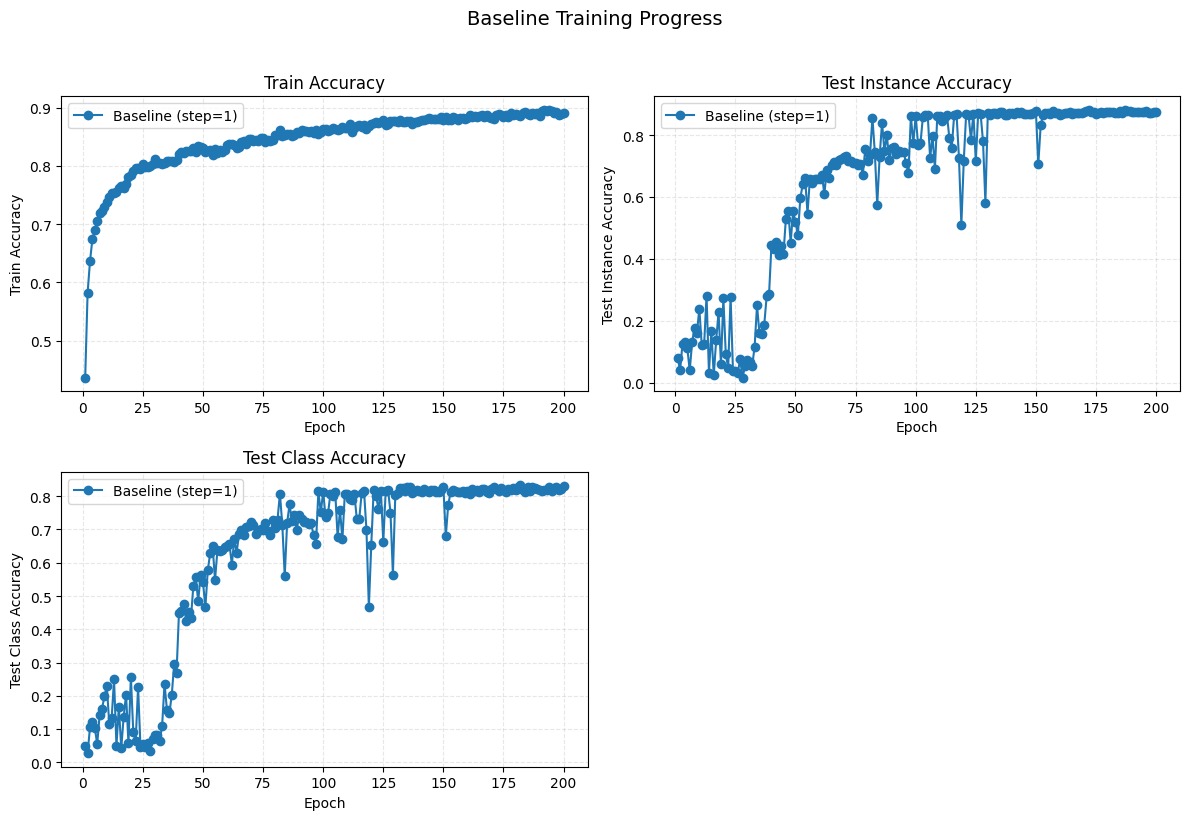

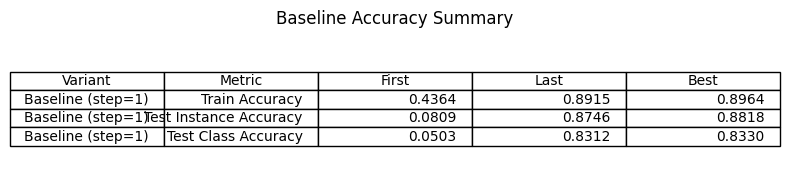

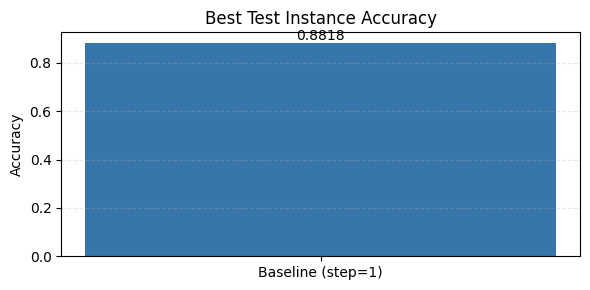

Final metrics:
  Train Accuracy: first=0.4364, last=0.8915, best=0.8964
  Test Instance Accuracy: first=0.0809, last=0.8746, best=0.8818
  Test Class Accuracy: first=0.0503, last=0.8312, best=0.8330


In [9]:
import matplotlib.pyplot as plt

print("=== Training Summary ===")
print(f"Best Instance Accuracy: {best_instance_acc:.4f}")
print(f"Best Class Accuracy: {best_class_acc:.4f}")
print(f"Best Epoch: {best_epoch}")

if not training_history:
    print('Training history is empty; run the training loop before plotting.')
else:
    metrics = {
        "Train Accuracy": ["train_acc"],
        "Test Instance Accuracy": ["test_instance_acc"],
        "Test Class Accuracy": ["test_class_acc"],
    }

    histories = {"Baseline (step=1)": training_history}

    fig, axes = plot_training_curves(
        histories,
        metrics,
        title="Baseline Training Progress"
    )

    figures_dir = exp_dir / "figures"
    figures_dir.mkdir(parents=True, exist_ok=True)
    curve_path = figures_dir / "baseline_training_curves.png"
    fig.savefig(curve_path, dpi=150, bbox_inches="tight")
    plt.show()

    summary_stats = summarize_histories(histories, metrics)
    table_fig, table_ax = plot_metric_table(
        summary_stats,
        title="Baseline Accuracy Summary",
        value_fmt="{:.4f}",
        include_first=True
    )
    table_path = figures_dir / "baseline_accuracy_summary.png"
    table_fig.savefig(table_path, dpi=150, bbox_inches="tight")
    plt.show()

    bar_fig, bar_ax = plot_metric_bars(
        summary_stats,
        metric_name="Test Instance Accuracy",
        title="Best Test Instance Accuracy",
        ylabel="Accuracy"
    )
    bar_path = figures_dir / "baseline_best_test_accuracy.png"
    bar_fig.savefig(bar_path, dpi=150, bbox_inches="tight")
    plt.show()

    def _fmt(value):
        return '-' if value is None else f"{value:.4f}"

    print("Final metrics:")
    stats = summary_stats["Baseline (step=1)"]
    for metric_name, metric_stats in stats.items():
        print(f"  {metric_name}: first={_fmt(metric_stats.get('first'))}, last={_fmt(metric_stats.get('last'))}, best={_fmt(metric_stats.get('best'))}")
